In [1]:
from __future__ import annotations
import time, random, tracemalloc
from pathlib import Path
from typing import Dict, List, Tuple
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass

In [2]:
# --------------------------
# 1. MLP-based MDP model
# --------------------------
class MLP_MDP(nn.Module):
    def __init__(self, n_states: int, n_actions: int,
                 hidden_sizes: Tuple[int, ...] = (128, 128), seed: int = 42):
        super().__init__()
        torch.manual_seed(seed)
        self.n_states, self.n_actions = n_states, n_actions
        layers: List[nn.Module] = []
        in_dim = n_states + n_actions
        for h in hidden_sizes:
            layers += [nn.Linear(in_dim, h), nn.ReLU()]
            in_dim = h
        self.trunk = nn.Sequential(*layers)
        self.trans_head = nn.Linear(in_dim, n_states)
        self.rew_head = nn.Linear(in_dim, 1)

    def forward(self, s_oh: torch.Tensor, a_oh: torch.Tensor):
        x = torch.cat([s_oh, a_oh], -1)
        h = self.trunk(x)
        probs = F.softmax(self.trans_head(h), -1)
        reward = self.rew_head(h).squeeze(-1)
        return probs, reward

    @torch.no_grad()
    def extract_P_R(self):
        P = torch.zeros(self.n_states, self.n_actions, self.n_states)
        R = torch.zeros(self.n_states, self.n_actions)
        for s in range(self.n_states):
            s_oh = F.one_hot(torch.tensor(s), self.n_states).float()
            for a in range(self.n_actions):
                a_oh = F.one_hot(torch.tensor(a), self.n_actions).float()
                probs, r = self.forward(s_oh, a_oh)
                P[s, a] = probs
                R[s, a] = r
        return P.numpy(), R.numpy()

In [3]:
# --------------------------
# 2. Util
# --------------------------

def set_global_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def one_hot(i: int, size: int):
    v = np.zeros(size, dtype=np.float32)
    v[i] = 1.
    return v


@dataclass
class DPResult:
    V: np.ndarray
    policy: np.ndarray
    history: Dict[str, List]
    time: float
    memory: int

def visualize_mlp_simple(env: MLP_MDP, save_path="results/mlp_architecture.png"):
    import matplotlib.pyplot as plt
    from matplotlib.patches import FancyBboxPatch

    labels = []
    in_dim = env.n_states + env.n_actions
    labels.append(f"Input\n{in_dim}")
    cur = in_dim
    for mod in env.trunk:
        if isinstance(mod, nn.Linear):
            labels.append(f"Linear\n{cur}→{mod.out_features}")
            cur = mod.out_features
        elif isinstance(mod, nn.ReLU):
            labels.append("ReLU")
    labels.append(f"P-head\n{cur}→{env.n_states}")
    labels.append(f"R-head\n{cur}→1")

    fig, ax = plt.subplots(figsize=(1.8*len(labels), 2.8))
    ax.set_axis_off()
    for i, txt in enumerate(labels):
        # 盒子
        box = FancyBboxPatch((i, 0), 1, 1,
                             boxstyle="round,pad=0.2",
                             edgecolor="black", facecolor="#DDEEFF")
        ax.add_patch(box)
        ax.text(i+0.5, 0.5, txt, ha="center", va="center", fontsize=10)
        # 箭头
        if i < len(labels)-1:
            ax.annotate("",
                        xy=(i+1, 0.5), xytext=(i+1-0.05, 0.5),
                        arrowprops=dict(arrowstyle="->", lw=1))
    ax.set_xlim(0, len(labels))
    ax.set_ylim(0, 1)
    plt.tight_layout()
    Path(save_path).parent.mkdir(exist_ok=True)
    plt.savefig(save_path, dpi=150)
    plt.close()
    print(f"网络结构图已保存到 {save_path}")

In [4]:
# --------------------------
# 3. policy evaluation
# --------------------------

def policy_evaluation(P, R, policy, gamma=0.95, eps=1e-5):
    S, A, _ = P.shape
    V = np.zeros(S)
    while True:
        delta = 0
        V_new = np.zeros_like(V)
        for s in range(S):
            V_new[s] = sum(policy[s, a] * (R[s, a] + gamma * P[s, a].dot(V)) for a in range(A))
            delta = max(delta, abs(V_new[s] - V[s]))
        V = V_new
        if delta < eps:
            return V

In [5]:
# --------------------------
# 4. algorithms (PI, VI, in-place, PS, sample-based)
# --------------------------

def greedy_policy(P, R, V, gamma):
    S, A, _ = P.shape
    pol = np.zeros((S, A))
    for s in range(S):
        q = [R[s, a] + gamma * P[s, a].dot(V) for a in range(A)]
        pol[s] = one_hot(int(np.argmax(q)), A)
    return pol


def make_dp_result(V, policy, history, start_mem, t0):
    return DPResult(V, policy, history, time.perf_counter() - t0, tracemalloc.get_traced_memory()[0] - start_mem)


def policy_iteration(P, R, gamma=0.95, eps=1e-5):
    S, A, _ = P.shape
    policy = np.ones((S, A)) / A
    hist = []
    tracemalloc.start()
    start = tracemalloc.get_traced_memory()[0]
    t0 = time.perf_counter()
    while True:
        V = policy_evaluation(P, R, policy, gamma, eps)
        stable = True
        for s in range(S):
            q = [R[s, a] + gamma * P[s, a].dot(V) for a in range(A)]
            best = int(np.argmax(q))
            if policy[s].argmax() != best: stable = False
            policy[s] = one_hot(best, A)
        hist.append(max(abs(V - policy_evaluation(P, R, policy, gamma, eps))))
        if stable: break
    return make_dp_result(V, policy, {"delta": hist}, start, t0)


def value_iteration(P, R, gamma=0.95, eps=1e-5):
    S, A, _ = P.shape
    V = np.zeros(S)
    hist = []
    tracemalloc.start()
    start = tracemalloc.get_traced_memory()[0]
    t0 = time.perf_counter()
    while True:
        delta = 0
        for s in range(S):
            q = [R[s, a] + gamma * P[s, a].dot(V) for a in range(A)]
            v_new = max(q)
            delta = max(delta, abs(v_new - V[s]))
            V[s] = v_new
        hist.append(delta)
        if delta < eps: break
    pol = greedy_policy(P, R, V, gamma)
    return make_dp_result(V, pol, {"delta": hist}, start, t0)


def in_place_value_iteration(P, R, gamma=0.95, eps=1e-5):
    S, A, _ = P.shape
    V = np.zeros(S)
    hist = []
    order = list(range(S))
    tracemalloc.start()
    start = tracemalloc.get_traced_memory()[0]
    t0 = time.perf_counter()
    while True:
        delta = 0
        for s in order:
            q = [R[s, a] + gamma * P[s, a].dot(V) for a in range(A)]
            v_new = max(q)
            delta = max(delta, abs(v_new - V[s]))
            V[s] = v_new
        hist.append(delta)
        if delta < eps: break
    pol = greedy_policy(P, R, V, gamma)
    return make_dp_result(V, pol, {"delta": hist}, start, t0)


def prioritized_sweeping(P, R, gamma=0.95, eps=1e-5, theta=1e-3):
    import heapq
    S, A, _ = P.shape
    V = np.zeros(S)
    preds = {s: [] for s in range(S)}
    for s in range(S):
        for a in range(A):
            for sp in range(S):
                if P[s, a, sp] > 0: preds[sp].append((s, a))

    def bell(state):
        q = [R[state, a] + gamma * P[state, a].dot(V) for a in range(A)]
        return abs(max(q) - V[state])

    pq = [(-bell(s), s) for s in range(S)]
    heapq.heapify(pq)
    hist = []
    tracemalloc.start()
    start = tracemalloc.get_traced_memory()[0]
    t0 = time.perf_counter()
    while pq:
        neg, s = heapq.heappop(pq)
        V[s] = max([R[s, a] + gamma * P[s, a].dot(V) for a in range(A)])
        for sp, _ in preds[s]:
            err = bell(sp)
            if err > theta: heapq.heappush(pq, (-err, sp))
        hist.append(bell(s))
        if len(hist) >= S and max(hist[-S:]) < eps: break
    pol = greedy_policy(P, R, V, gamma)
    return make_dp_result(V, pol, {"delta": hist}, start, t0)


# sample-based
class ValueNet(nn.Module):
    def __init__(self, n_states, hidden=(128, 128)):
        super().__init__()
        layers = []
        d = n_states
        for h in hidden:
            layers += [nn.Linear(d, h), nn.ReLU()]
            d = h
        layers.append(nn.Linear(d, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, s): return self.net(s).squeeze(-1)


def sample_based_value_iteration(env, gamma=0.95, iters=4000, batch=256, lr=3e-4):
    torch.manual_seed(0)
    n_states, n_actions = env.n_states, env.n_actions
    net = ValueNet(n_states)
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    all_s = F.one_hot(torch.arange(n_states), n_states).float()
    all_a = F.one_hot(torch.arange(n_actions), n_actions).float()
    hist = []
    tracemalloc.start()
    start = tracemalloc.get_traced_memory()[0]
    t0 = time.perf_counter()
    for _ in range(iters):
        idx_s = torch.randint(0, n_states, (batch,))
        idx_a = torch.randint(0, n_actions, (batch,))
        s_oh = all_s[idx_s]
        a_oh = all_a[idx_a]
        with torch.no_grad():
            Psa, Rsa = env.forward(s_oh, a_oh)
            cum = torch.cumsum(Psa, -1)
            nxt = (cum >= torch.rand(batch, 1)).float().argmax(-1)
            target = Rsa + gamma * net(all_s[nxt])
        pred = net(s_oh)
        loss = F.mse_loss(pred, target)
        opt.zero_grad()
        loss.backward()
        opt.step()
        hist.append(loss.item())
    with torch.no_grad(): V = net(all_s).numpy(); P, R = env.extract_P_R()
    pol = greedy_policy(P, R, V, gamma)
    return make_dp_result(V, pol, {"loss": hist}, start, t0)


# brute-force best

def policy_return(P, R, policy, gamma=0.95):
    return policy_evaluation(P, R, policy, gamma).mean()


def brute_force_optimal_return(P, R, gamma=0.95):
    S, A, _ = P.shape
    best = -np.inf
    best_pol = None
    for idx in range(A ** S):
        digits = np.base_repr(idx, base=A).zfill(S)
        pol = np.zeros((S, A))
        for s, d in enumerate(digits): pol[s, int(d)] = 1
        ret = policy_return(P, R, pol, gamma)
        if ret > best: best, best_pol = ret, pol.copy()
    return best, best_pol

随机策略价值: [-1.49396658 -1.49905563 -1.45143666 -1.47842342 -1.49278395]
理论最优平均折扣回报: -0.842270
              algorithm  iterations   time_sec  memory_bytes  policy_return
0      Policy Iteration           2   0.144895        151875       -0.84227
1       Value Iteration         106   0.019007          5140       -0.84227
2           In-Place VI         106   0.019408          4244       -0.84227
3  Prioritized Sweeping         100   0.062225         44273       -0.84227
4       Sample-Based VI        4000  12.129662        147761       -0.84227
实验完成，结果已保存至 results/ 目录。


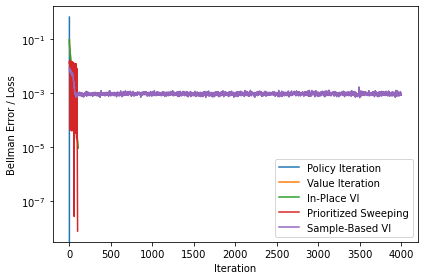

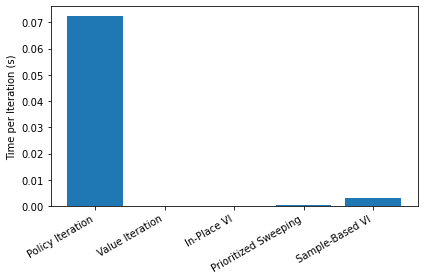

In [6]:
def main():
    gamma = 0.95
    eps = 1e-5
    hidden = (64, 64)
    seed = 42
    set_global_seed(seed)
    Path("results").mkdir(exist_ok=True)
    depths = [(32,), (64, 64), (128, 128, 128)]
    legality = []
    for h in depths:
        env = MLP_MDP(5, 3, h, seed=123)
        P, _ = env.extract_P_R()
        for s in range(5):
            for a in range(3):
                legality.append({"depth": len(h), "sum_P": P[s, a].sum()})
    pd.DataFrame(legality).to_csv("results/legality.csv", index=False)

    env = MLP_MDP(5, 3, hidden, seed=seed)
    visualize_mlp_simple(env)
    P, R = env.extract_P_R()
    rand_pol = np.ones((5, 3)) / 3
    print("随机策略价值:", policy_evaluation(P, R, rand_pol, gamma, eps))
    best_ret, _ = brute_force_optimal_return(P, R, gamma)
    print(f"理论最优平均折扣回报: {best_ret:.6f}")

    results = {
        "Policy Iteration": policy_iteration(P, R, gamma, eps),
        "Value Iteration": value_iteration(P, R, gamma, eps),
        "In-Place VI": in_place_value_iteration(P, R, gamma, eps),
        "Prioritized Sweeping": prioritized_sweeping(P, R, gamma, eps),
        "Sample-Based VI": sample_based_value_iteration(env, gamma)
    }

    summary = []
    for name, res in results.items():
        summary.append({
            "algorithm": name,
            "iterations": len(next(iter(res.history.values()))),
            "time_sec": res.time,
            "memory_bytes": res.memory,
            "policy_return": policy_return(P, R, res.policy, gamma)
        })
    df = pd.DataFrame(summary)
    df.to_csv("results/summary.csv", index=False)
    print(df)

    plt.figure()
    for name, res in results.items():
        k = "delta" if "delta" in res.history else "loss"
        plt.plot(res.history[k], label=name)
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("Bellman Error / Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig("results/convergence.png")

    plt.figure()
    plt.bar(df["algorithm"], df["time_sec"] / df["iterations"])
    plt.ylabel("Time per Iteration (s)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.savefig("results/time_per_iter.png")
    print("实验完成，结果已保存至 results/ 目录。")


if __name__ == "__main__":
    main()
